# Data pre-processing

In [1]:
# Necessary modules
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import string
import torch

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt


In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kajud\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kajud\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kajud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Loading cleaned data
df_purged = pd.read_csv("data/Movies_and_TV_5_purged_balanced.csv")
df_purged = df_purged.dropna()

In [3]:
len(df_purged)

1080672

In [4]:
df_purged.head()

,Unnamed: 0,reviewText,overall,label
0,0,"Pearl's story is inspiring, to say the least. ...",5.0,2.0
1,1,Love this show,5.0,2.0
2,2,Whats so great about this film is that one act...,5.0,2.0
3,3,Great.,5.0,2.0
4,4,What can I say but a true classic!,5.0,2.0


## 1. Balancing dataset

In [8]:
from sklearn.utils import resample
# Separate positive, neutral and negative classes
df_pos = df_purged[df_purged.label==2]
df_neut = df_purged[df_purged.label==1]
df_neg = df_purged[df_purged.label==0]
n_sample = len(df_neg) #in case of movie dataset
# n_sample = 600000  #in case of sports dataset
print(n_sample)
# Downsample majority class
df_pos_downsampled = resample(df_pos, 
                              replace=False,    # sample without replacement
                              n_samples=n_sample,     # to match minority classes
                              random_state=123) # reproducible results
 
# Combine minority classes with downsampled majority class
df_purged = pd.concat([df_pos_downsampled, df_neut, df_neg])
 
# Display new class counts
df_purged.label.value_counts()

365517


2.0    365517
0.0    365517
1.0    349638
Name: label, dtype: int64

In [9]:
# reset indices after balancing
df_purged = df_purged[['reviewText', 'overall', 'label']].reset_index(drop=True)

In [10]:
# save balanced dataset for later use
df_purged.to_csv("data/Movies_and_TV_5_purged_balanced.csv")

In [11]:
# check how balanced the training dataset is
df_purged.groupby(['label']).count()

,reviewText,overall
label,,
0.0,365517,365517
1.0,349638,349638
2.0,365517,365517


In [6]:
# check the list of stopwords -> we didn't remove stopwords at the end in order to keep very important words e.g "not"
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## 2. We performed the following pre-processing steps:

 1. Replaceing contractions: e.g "don't" -> "do not"
 2. Removing URLs
 3. Removing usernames
 4. Converting text to lowercase
 5. Removing HTML tags
 6. Removing punctuation marks and multiple spaces
 7. Removing numbers
 8. Tokenizing sentence: e.g "this is an example" -> ['this', 'is', 'an', 'example']
 9. Removing one letter long words

In [7]:
# replacing contraction with their clear form
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [8]:
def preprocess_text(text):
    
    # stop_words = set(stopwords.words('english'))
    text = replace_contractions(text)
    # removing url-s
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', text)
    # removing usernames-s
    text = re.sub('@[^\s]+','', text)
    # converting text to lowercase
    text = text.lower()
    # remove HTML tags
    text = re.sub('<.*?>', '', text)
    # remove punctuation marks
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # remove multiple spaces
    text = re.sub(' +',' ', text)
    # removing numbers
    text = re.sub(r'\w*\d+\w*', '', text)
    # tokenizing sentence
    tokens = word_tokenize(text)
    # remove one letter long "words"
    cleaned_text = [w for w in tokens if len(w)>=2]
    
    return cleaned_text


In [9]:
text_prep = [preprocess_text(t) for t in tqdm(df_purged.reviewText)]

  0%|          | 0/1080672 [00:00<?, ?it/s]

In [10]:
df_purged["reviewText"] = text_prep

In [11]:
df_purged.head()

,Unnamed: 0,reviewText,overall,label
0,0,"[pearl, story, is, inspiring, to, say, the, le...",5.0,2.0
1,1,"[love, this, show]",5.0,2.0
2,2,"[whats, so, great, about, this, film, is, that...",5.0,2.0
3,3,[great],5.0,2.0
4,4,"[what, can, say, but, true, classic]",5.0,2.0


In [12]:
# Save preprocessend dataset for later use
df_purged.to_pickle("data/Movies_and_TV_5_purged_balanced_with_stopwords.pkl")

In [12]:
df_purged = pd.read_pickle("data/Movies_and_TV_5_prep_tokenized_debug.pkl")

## 3. Determining reasonable maximum sentence length (eliminating outliers)

In [19]:
df_purged['len'] = df_purged['reviewText'].apply(lambda s : len(s))

<AxesSubplot:ylabel='Frequency'>

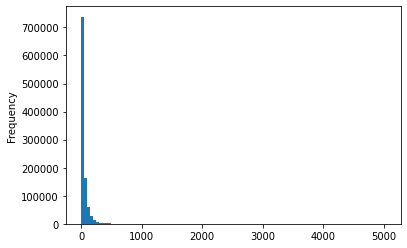

In [20]:
df_purged['len'].plot.hist(bins=100)

In [22]:
df_purged.len.quantile(0.9)

111.0